# Document Classification with CNN [Part 2] - Model Building

* Solved By: Pradip Dharam
* Objective: Preprocess docs, train multiple ConvNets to classify docs with achieve upto 70% accuracy etc.
* Part 1 [Another Notebook]: Preprocessing of all 18828 files. Features preprocessed_email, preprocessed_subjects, preprocessed_texts to be extracted.
* Part 2 [Covered]: Multiple ConvNets models to be trained.
* Part 3 [Not Covered]: 

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf. __version__) 

Num GPUs Available:  1
2.7.0


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt

import matplotlib
import tkinter
#matplotlib.use('TkAgg')
#matplotlib.use('Agg')
#import probscale
import seaborn as sns

In [3]:
from tensorflow import keras 
from tensorflow.keras import Sequential, Model

In [4]:
import tensorflow.compat.v2 as tf
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, LSTM 
from tensorflow.keras.layers import concatenate, Dropout, Conv1D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import tensorflow_addons as tfa

import tensorflow as tf
import datetime
import time as time

In [5]:
#!pip install tensorflow-addons

In [6]:
#"UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure."
#!pip install pyqt5

## Train Test Splits - Stratified

In [7]:
df = pd.read_excel("Preprocessed_Documents_60778.xlsx")

In [8]:
df['combined'] = df.preprocessed_text + ' ' + df.preprocessed_subject + ' ' + df.preprocessed_emails

In [9]:
df.drop(['Unnamed: 0', 'document_name', 'text', 'preprocessed_text',
       'preprocessed_subject', 'preprocessed_emails'], axis=1, inplace=True)

In [10]:
df.columns

Index(['class', 'combined'], dtype='object')

In [11]:
df['class'].isna().sum()

0

In [12]:
df.isna().sum()

class         0
combined    129
dtype: int64

In [13]:
df.shape

(18828, 2)

In [14]:
df = df[pd.notnull(df['combined'])].reset_index().filter(['combined', 'class'])
df

,combined,class
0,atheism resources resources december atheist r...,alt.atheism
1,atheism introduction introduction april begin ...,alt.atheism
2,article well has quite different not necessari...,alt.atheism
3,recently ras have been ordered and none have r...,alt.atheism
4,article however hate economic terrorism and po...,alt.atheism
...,...,...
18694,was not sure this was the right newsgroup post...,talk.religion.misc
18695,article article probably not but then not pack...,talk.religion.misc
18696,article you would like understand better the s...,talk.religion.misc
18697,article the danger anti cult groups that while...,talk.religion.misc


In [15]:
df.shape

(18699, 2)

In [16]:
df.isna().sum()

combined    0
class       0
dtype: int64

In [17]:
X = df['combined']
y = df['class']
print(X.shape)
print(y.shape, y[0])

(18699,)
(18699,) alt.atheism


In [18]:
X.isna().sum()

0

In [19]:
type(X)

pandas.core.series.Series

In [20]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
sss.get_n_splits(X, y)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("train_index:", train_index, "test_index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=2, random_state=0, test_size=0.25,
            train_size=None)
train_index: [15109 10406  9947 ... 10668  3767 16491] test_index: [  138  2914 17633 ... 14323 12225  8836]
train_index: [ 4222  6505  2178 ... 12066 13209  7769] test_index: [18612   968   514 ...  1585 18418  3229]


In [21]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(14024,) (4675,)
(14024,) (4675,)


### Plotting class distributions

In [22]:
def plot_class_counts_histogrem(y_train):
    dict_class_counts = dict(Counter(y_train))
    class_document_counts = pd.Series(dict_class_counts)
    #https://stackoverflow.com/questions/29525120/pandas-creating-a-histogram-from-string-counts
    plt.bar(range(len(class_document_counts)), \
            class_document_counts.values, align='center')
    plt.xticks(range(len(class_document_counts)), \
               class_document_counts.index.values, size='large', rotation='vertical')
    plt.show()

#### Train Set

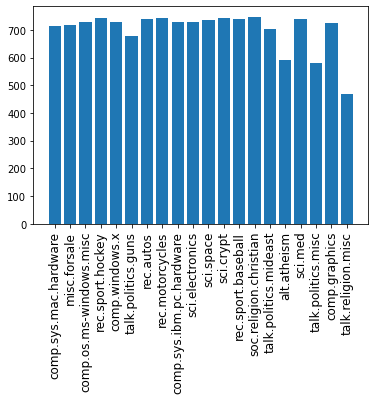

In [23]:
plot_class_counts_histogrem(Y_train)

#### Test Set

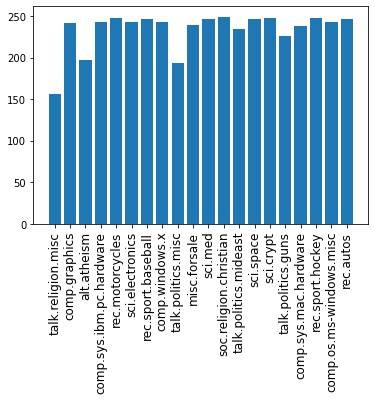

In [24]:
plot_class_counts_histogrem(Y_test)

Distribution of classes across train and test sets looks similar

## Analyzing prepeocessed text
We should check X_train only to avoid the data leakage. X_train here in concatenation of features preprocessed_text, df.preprocessed_subject and preprocessed_emails.

### Texts sequence lengths analysis

In [25]:
X_train[0][0:100]

'atheism resources resources december atheist resources addresses atheist organizations usa freedom f'

In [26]:
len(X_train[0]) #Number of character in X_train[0]

8139

In [27]:
text_lengths = pd.Series([len(sequence.split()) for sequence in X_train])

In [28]:
#text_lengths

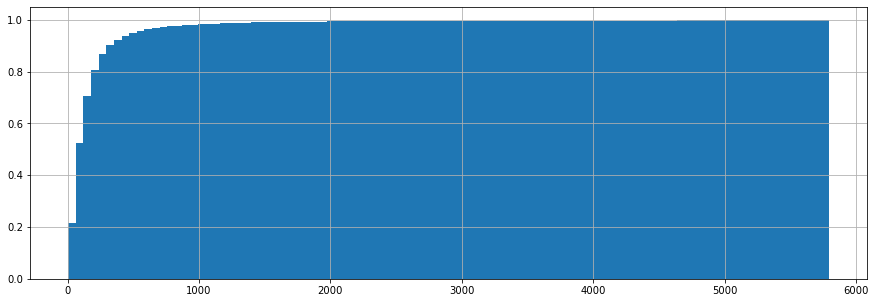

In [29]:
def plot_percentiles(numbers):
    #https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python
    fig = plt.figure(figsize = (15,5))
    ax = fig.gca()
    numbers.hist(ax = ax, cumulative=True, density=1, bins=100)

plot_percentiles(text_lengths)

In [30]:
text_lengths.quantile(q=0.85)

274.0

In [31]:
text_lengths.quantile(q=.9)

348.0

In [32]:
text_lengths.quantile(q=.95)

530.8499999999985

In [33]:
text_lengths.quantile(q=.99)

1400.0800000000017

85% of the records or sequences are below the length 348

In [34]:
max_sequence_length = 274

### Checking the counts of each unique word in the combined prepeocessed text

In [35]:
scalar = TfidfVectorizer(ngram_range=(1, 1), use_idf=True) #in scikit-learn
tfidf  = scalar.fit_transform(X_train)

In [36]:
vocab_data = scalar.get_feature_names()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
vocab_data[0:5]

['00', '000', '007', '008', '01']

In [38]:
len(vocab_data)

86581

### Creating zero padded sequences of numbers

I am going to incorporate similar vectorize_layer while creating actual model

This is how the vectorize_layer works!

In [39]:
#Keras documentation itself
#https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/
#This is not the exact copied code, its modified after.

vocab_data_sample = ["foo", "bar", "baz"]
max_features = len(vocab_data_sample) + 2 # Maximum vocab size.
max_len = 5  # Sequence length to pad the outputs to.

# Create the layer, passing the vocab directly. You can also pass the
# vocabulary arg a path to a file containing one vocabulary word per
# line.
vectorize_layer = tf.keras.layers.TextVectorization(
                    max_tokens=max_features,
                    output_mode='int',
                    output_sequence_length=max_len,
                    vocabulary=vocab_data_sample)



 # Because we've passed the vocabulary directly, we don't need to adapt
 # the layer - the vocabulary is already set. The vocabulary contains the
 # padding token ('') and OOV token ('[UNK]') as well as the passed tokens.
vectorize_layer.get_vocabulary()
#['', '[UNK]', 'earth', 'wind', 'and', 'fire']

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
input_data = [["foo qux bar hello"], ["qux baz"], ["foo qux bar hello qux baz"]]
model.predict(input_data)

array([[2, 1, 3, 1, 0],
       [1, 4, 0, 0, 0],
       [2, 1, 3, 1, 1]], dtype=int64)

Lets check on actual dataset

In [40]:
#print(vocab_data)

In [41]:
#Keras documentation itself
#https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/

#vocab_data - unique words in training dataset
max_features = len(vocab_data) + 2 # Maximum vocab size.
#max_len = max_sequence_length  # Sequence length to pad the outputs to.

# Create the layer, passing the vocab directly. You can also pass the
# vocabulary arg a path to a file containing one vocabulary word per
# line.
vectorize_layer = tf.keras.layers.TextVectorization(
max_tokens=max_features,
output_mode='int',
output_sequence_length=max_sequence_length,
vocabulary=vocab_data)

 # Because we've passed the vocabulary directly, we don't need to adapt
 # the layer - the vocabulary is already set. The vocabulary contains the
 # padding token ('') and OOV token ('[UNK]') as well as the passed tokens.
vectorize_layer.get_vocabulary()
#['', '[UNK]', 'earth', 'wind', 'and', 'fire']

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

print(X_train[0:5])
temp_sequences = model.predict(X_train[0:5].to_numpy())
print(temp_sequences)

4222    have had running with mhz osc for few months h...
6505    looking for copy last film anyone has copy thi...
2178    article hey does anyone know ftp site where ca...
9774    for updated playoff updates mail with the subj...
4827    trying implement pointer feature xlib have mul...
Name: combined, dtype: object
[[31667 31056 64594 ...     0     0     0]
 [42912 27000 15124 ...     0     0     0]
 [ 4581 32314 20232 ...     0     0     0]
 [27000 78575 56660 ...     0     0     0]
 [76192 35158 56974 ...     0     0     0]]


Below vocablary and sequences created will be used later

In [42]:
#This will be used to extract embedding vectors fro GloVe for each word in vocablary ...
# using the index of the word in this vocab_produced list
vocab_produced = vectorize_layer.get_vocabulary()

#This will be used as input to the keras Input later of the model.
x_train_sequences = model.predict(X_train)
x_test_sequences  = model.predict(X_test.values)

Create y_train

In [43]:
Y_train = Y_train.str.replace('-','_')
Y_train = Y_train.str.replace('.','_')

Y_test = Y_test.str.replace('-','_')
Y_test = Y_test.str.replace('.','_')

C:\Users\Pradip\AppData\Local\Temp/ipykernel_5508/2905364387.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Y_train = Y_train.str.replace('.','_')
C:\Users\Pradip\AppData\Local\Temp/ipykernel_5508/2905364387.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Y_test = Y_test.str.replace('.','_')


In [44]:
label_corpus = ' '.join([str(e) for e in Y_train.unique()])
print(label_corpus)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(Y_train)

comp_sys_mac_hardware misc_forsale comp_os_ms_windows_misc rec_sport_hockey comp_windows_x talk_politics_guns rec_autos rec_motorcycles comp_sys_ibm_pc_hardware sci_electronics sci_space sci_crypt rec_sport_baseball soc_religion_christian talk_politics_mideast alt_atheism sci_med talk_politics_misc comp_graphics talk_religion_misc


CountVectorizer()

In [45]:
y_train = vectorizer.transform(Y_train).toarray()
y_test  = vectorizer.transform(Y_test) .toarray()

In [46]:
y_train[0:5]

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

In [47]:
Y_train[0:5]

4222      comp_sys_mac_hardware
6505               misc_forsale
2178    comp_os_ms_windows_misc
9774           rec_sport_hockey
4827             comp_windows_x
Name: class, dtype: object

In [48]:
vectorizer.get_feature_names_out()

array(['alt_atheism', 'comp_graphics', 'comp_os_ms_windows_misc',
       'comp_sys_ibm_pc_hardware', 'comp_sys_mac_hardware',
       'comp_windows_x', 'misc_forsale', 'rec_autos', 'rec_motorcycles',
       'rec_sport_baseball', 'rec_sport_hockey', 'sci_crypt',
       'sci_electronics', 'sci_med', 'sci_space',
       'soc_religion_christian', 'talk_politics_guns',
       'talk_politics_mideast', 'talk_politics_misc',
       'talk_religion_misc'], dtype=object)

Alternate approch to create right padded sequences of numbers.
* tf.keras "Tokenizer" API, it removes the "_"

In [49]:
'''
#Below approach also can be used to create the right padded sequences of numbers.
#Since I am going to use above vectorize_layer, below code I have not tested.
t = Tokenizer()
t.fit_on_texts(word_corpus)
vocab_size = len(t.word_index) + 1
print("Number of unique words: ", vocab_size)
# integer encode the documents
x_train = t.texts_to_sequences(X_train)
x_test  = t.texts_to_sequences(X_test)
'''

'\n#Below approach also can be used to create the right padded sequences of numbers.\n#Since I am going to use above vectorize_layer, below code I have not tested.\nt = Tokenizer()\nt.fit_on_texts(word_corpus)\nvocab_size = len(t.word_index) + 1\nprint("Number of unique words: ", vocab_size)\n# integer encode the documents\nx_train = t.texts_to_sequences(X_train)\nx_test  = t.texts_to_sequences(X_test)\n'

## Figuring out for models to be trained

##### getting my brain dirty, not hands! 

Metrics to be considered
* "categorical_crossentropy" as Loss
*  Accuracy and Micro Avgeraged F1 score as my as Key metrics to evaluate my model

Model weights and results visualization
* Tensorboard to plot the loss and Metrics based on the epoches
* I can save save my best model weights in to 'best_model_L.h5' ( L = 1 or 2 )
* I am going to save my model to image ( can plot the model) with shapes and inlcude those images in the notebook markdown cell. I can use "plot model"
* Plotting model with shapes can be checked here https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

I need to decide below parameters
* Activation function, learning rate, optimizer.

Early Stopping technique or any of the callback techniques can be used !

Encoding of the Text --> 
* For a given text data create a Matrix with Embedding layer as shown Below. 
* In the example we have considered d = 5, but in this assignment we will get d = dimension of Word vectors we are using.
* i.e if we have maximum of 350 words in a sentence and embedding of 300 dim word vector, we result in 350*300 dimensional matrix for each sentance as output after embedding layer
* <img src="https://i.imgur.com/kiVQuk1.png" alt="drawing" width="200">
* https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

#### How embedding Layer works?
* Embedding(7, 2, input_length=5)
* Embedding(unique_numbers_in_sequences, output_length, input_length=5)
* For each number it creates the vector of length 2
* It creates 7 vectors of dimensiobn 2 each
* For each number in the input sequence, it replaces the respective vector. 

https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

Embedding(7, 2, input_length=5)

* +------------+------------+
* |   index    |  Embedding |
* +------------+------------+
* |     0      | [1.2, 3.1] |
* |     1      | [0.1, 4.2] |
* |     2      | [1.0, 3.1] |
* |     3      | [0.3, 2.1] |
* |     4      | [2.2, 1.4] |
* |     5      | [0.7, 1.7] |
* |     6      | [4.1, 2.0] |
* +------------+------------+

Inputs:

[0, 1, 2, 3, 4]

[5, 1, 2, 3, 6]

Output (for second input vector):

[[0.7, 1.7], [0.1, 4.2], [1.0, 3.1], [0.3, 2.1], [4.1, 2.0]]

##### Thanks not all folks, model is yet to be trained! :P

## Embedding using GloVe vector
#### Preparing the Embedding layer using GloVe vector
* Read about "Global Vectors for Word Representation" here https://nlp.stanford.edu/projects/glove/
* glove.6B.300d.txt is downloaded from here http://nlp.stanford.edu/data/glove.6B.zip

In [50]:
#Code copied from Keras documentation itself. And modified slighly according to my requirement
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index = {}
GLOVE_DIR = '.'
EMBEDDING_DIM = 300

f = open(os.path.join(GLOVE_DIR, 'glove.6B.' + str(EMBEDDING_DIM) + 'd.txt'), encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

vocab_not_in_glov = []
embedding_matrix = np.zeros((len(vocab_produced), EMBEDDING_DIM))
for i in tqdm(np.arange(len(vocab_produced))):
    word = vocab_produced[i]    
    embedding_vector = embeddings_index.get(word)
    #print(i,word, embedding_vector)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        vocab_not_in_glov.append(word)

400000it [00:33, 11859.27it/s]


Found 400000 word vectors.


100%|████████████████████████████████████████████████████████████████████████| 86583/86583 [00:00<00:00, 408416.09it/s]


In [51]:
print(len(vocab_produced))
print(len(vocab_not_in_glov))

86583
34781


In [52]:
print(vocab_not_in_glov[0:200])

['', '[UNK]', '02at', '04g', '0a', '0dv', '0f0064', '0f3', '0jv', '0jz', '0x000c', '0x0069', '1000w', '100ns', '1028x1024', '1084s', '10w40', '110v', '1200dpi', '120mb', '120v', '120vac', '125mb', '1280x1024', '1304s', '130mb', '130mhd', '13k', '1440k', '144mhz', '146gtl', '14in', '150w', '1542a', '1542b', '154m', '1600x1200x256', '16242', '16550', '16550a', '165c', '16mhz', '180mb', '1bil', '1meg', '1ph4', '1pl7', '1py', '200a', '200cd', '20mb', '20mhz', '20w50', '210m', '22600', '2400bps', '240at', '24bit', '24gc', '24sx', '25mhz', '2623a', '27c64', '27x', '280z', '2a0du48', '2ci', '2mtr', '2sa634', '2sc1096', '2themax', '300e', '300i', '30826', '30d', '30mb', '3144', '32bis', '32bit', '32plus', '3300sl', '33dx', '33mhz', '33v', '340sy', '3479p', '360k', '36pcs', '376h', '386dx', '386i', '386sl', '386sx', '3c503', '3ci', '3cm9809', '3comm', '3d2', '3dbench', '3dd', '3dh', '3dh4', '3dstudio', '3dy', '3hp', '3watt', '4000s', '40mhz', '40sc', '41m', '440mhz', '44mb', '44mg', '4778', '48

## Model 1

* Layer to convert 'sequences of words'  to 'right padded sequencees of numbers'
* 'Sequences of words' here is all data points in X_train

Model 1 which I am going to create

<img src="https://i.imgur.com/fv1GvFJ.png" alt="drawing" width="400">

#### Defining the model 1

In [53]:
print(len(x_train_sequences[0]))
max_length = x_train_sequences.shape[1]
print(max_length)

274
274


In [54]:
print(x_train_sequences)

[[31667 31056 64594 ...     0     0     0]
 [42912 27000 15124 ...     0     0     0]
 [ 4581 32314 20232 ...     0     0     0]
 ...
 [46981 81391 82832 ...     0     0     0]
 [20232  3673 40196 ...     0     0     0]
 [ 7342 70712 63077 ...     0     0     0]]


In [55]:
print(x_train_sequences.shape)
print(embedding_matrix.shape)

(14024, 274)
(86583, 300)


In [56]:
input_layer1      = Input(shape=(max_length,), name='input_layer1')

#embedding_matrix here has index wize words matrix; One array per one word.
#Index is sequence number here.
x  = Embedding(len(vocab_produced),
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False) (input_layer1)


i1            = Conv1D(8,  2, padding='same', strides = 1, activation='relu', \
                           kernel_initializer = tf.keras.initializers.HeUniform())(x)

i2            = Conv1D(8,  2, padding='same', strides = 1, activation='relu' , \
                           kernel_initializer = tf.keras.initializers.HeUniform() )(x)
 
i3           = Conv1D(8, 2 , padding='same', strides = 1, activation='relu', \
                           kernel_initializer = tf.keras.initializers.HeUniform() )(x)

x            = concatenate([i1, i2, i3])


x   = MaxPool1D(2, padding='same', strides=1, \
                             name='maxpool_layer4')(x)


i4    = Conv1D(5,   2, padding='same', strides = 2, activation='relu', \
                    kernel_initializer = tf.keras.initializers.HeUniform() )(x)
i5   = Conv1D(5,  2, padding='same', strides = 2, activation='relu', \
                           kernel_initializer = tf.keras.initializers.HeUniform() )(x)
i6   = Conv1D(5,  2, padding='same', strides = 2, activation='relu', \
                           kernel_initializer = tf.keras.initializers.HeUniform() )(x)
x    = concatenate([i4, i5, i6])


x   = MaxPool1D(2, padding='same', strides = 1, \
                             name='maxpool_layer6')(x)

x    = Conv1D(4, 3, padding='valid', activation='relu', \
                               kernel_initializer = tf.keras.initializers.HeUniform())(x)
                        #16 number of filters with kernel or filter size 4
    
x       = Flatten()(x)
x       = Dropout(0.1)(x)
x       = Dense(16, activation='relu', kernel_initializer= 'glorot_normal' ,  kernel_regularizer = tf.keras.regularizers.l2(l = 0.005) )(x)
x       = Dropout(0.1)(x)

dense_softmax = Dense(20, activation='softmax', kernel_initializer = 'glorot_normal' , name='dense_softmax')(x)

Model1 summary

In [57]:
#model1 = Model(inputs=inputs_, outputs=outputs_)
model1 = Model(inputs=input_layer1, outputs=dense_softmax)
print("Model Summary:")
model1.summary()

Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer1 (InputLayer)      [(None, 274)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 274, 300)     25974900    ['input_layer1[0][0]']           
                                                                                                  
 conv1d (Conv1D)                (None, 274, 8)       4808        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 274, 8)       4808        ['embedding[0][0]']              
                                                                               

Adjusting learninng rate across multiple trials based on inference for from training the model

In [58]:
#lr = 0.1 #Not ok
#lr = 0.005 #Not ok
#lr = 0.001 #Adam default
#lr = 0.0005
#lr = 1
#lr = 10
#lr = 100 # Not ok 43% accuracy
#lr = 500
#lr = 1000 #ok
#lr = 10000
#opt = tf.keras.optimizers.Adam(#learning_rate=lr,
#                               #clipnorm=1 )

model1.compile(optimizer = tf.keras.optimizers.Adam(), 
               loss      ='categorical_crossentropy', 
               metrics   =['accuracy'
                            #tf.keras.metrics.Accuracy()
                            #, tfa.metrics.F1Score(num_classes=20, threshold= 0.5, average='micro')
                            , tfa.metrics.FBetaScore(num_classes=20, threshold= 0.5, average='micro')
                           ])
print("Model Compiled!")

Model Compiled!


#### Defining Callbacks

##### Tensorboard Callback

In [59]:
%load_ext tensorboard
log_dir="logs_tsboard/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      write_graph=True,
                                                      write_grads=True)

Run this command in command prompt while model is getting trained
* %tensorboard --logdir logs_tsboard/fit/

#### Early Stopping and Model Checkpoint Callbacks

In [60]:
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# patient early stopping
es = EarlyStopping(monitor='val_fbeta_score', mode='max', min_delta=0.001, verbose=1, patience=10)
mc = ModelCheckpoint('best_model1.h5', monitor='val_fbeta_score', mode='max', verbose=1, save_best_only=True)

In [61]:
y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

#### Fit or train the model

In [62]:
x_train = x_train_sequences
x_test  = x_test_sequences

model_history1 = model1.fit(x_train, y_train
                            , validation_data=(x_test, y_test)
                            , epochs=50, batch_size=256, verbose=1
                            , callbacks=[tensorboard_callback, es, mc]
                           )

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 3.1228 - accuracy: 0.0596 - fbeta_score: 0.0000e+00
Epoch 00001: val_fbeta_score improved from -inf to 0.00000, saving model to best_model1.h5
55/55 [==============================] - 18s 256ms/step - loss: 3.1228 - accuracy: 0.0596 - fbeta_score: 0.0000e+00 - val_loss: 3.0538 - val_accuracy: 0.0682 - val_fbeta_score: 0.0000e+00
Epoch 2/50
55/55 [==============================] - ETA: 0s - loss: 2.8896 - accuracy: 0.1122 - fbeta_score: 0.0241
Epoch 00002: val_fbeta_score improved from 0.00000 to 0.04696, saving model to best_model1.h5
55/55 [==============================] - 10s 183ms/step - loss: 2.8896 - accuracy: 0.1122 - fbeta_score: 0.0241 - val_loss: 2.5445 - val_accuracy: 0.1981 - val_fbeta_score: 0.0470
Epoch 3/50
55/55 [==============================] - ETA: 0s - loss: 2.3346 - accuracy: 0.2238 - fbeta_score: 0.0893
Epoch 00003: val_fbeta_score improved from 0.04696 to 0.12842, saving model to best_model1.h5
5

### Exploring the best model

#### Load the best saved model by Model Checkpoint Callback

In [63]:
best_model1 = load_model('best_model1.h5')
# evaluate the model
_, train_acc, train_fbeta_score = best_model1.evaluate(x_train, y_train, verbose=1)
_, test_acc, test_fbeta_score = best_model1.evaluate(x_test, y_test, verbose=1)
print('train_acc: %.3f, test_acc: %.3f' % (train_acc, test_acc))
print('train_fbeta_score: %.3f, test_fbeta_score: %.3f' % (train_fbeta_score, test_fbeta_score))

147/147 [==============================] - 1s 8ms/step - loss: 1.1670 - accuracy: 0.6659 - fbeta_score: 0.6679
train_acc: 0.857, test_acc: 0.666
train_fbeta_score: 0.840, test_fbeta_score: 0.668


In [64]:
#### Load the best saved model by Model Checkpoint Callback

In [65]:
y_train_pred = best_model1.predict(x_train)
y_test_pred = best_model1.predict(x_test)

#### Exploring how predicted probabilities looks with respect

In [66]:
pd.Series([proba.max() for proba in y_train_pred]).value_counts()

1.000000    168
1.000000     50
1.000000     27
1.000000     19
1.000000     17
           ... 
0.291693      1
0.999291      1
0.657371      1
0.676305      1
0.996043      1
Length: 13371, dtype: int64

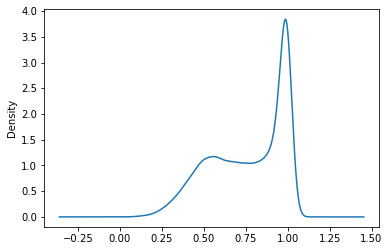

In [67]:
ax=pd.Series([proba.max() for proba in y_train_pred]).plot.kde()

In [68]:
[proba.max() for proba in y_train_pred][0:5]

[0.5625104, 0.44464308, 0.64242744, 0.98608065, 0.7255166]

In [69]:
#https://www.pythonprogramming.in/suppress-scientific-notation-in-numpy.html
np.set_printoptions(suppress=True,
                    formatter={'float_kind': '{:f}'.format})

In [70]:
print(y_train_pred[0])
print(y_train_pred[0].sum())

[0.000000 0.000006 0.000021 0.285069 0.562510 0.000000 0.101171 0.000005
 0.000000 0.000000 0.000000 0.000000 0.051219 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000]
0.9999999


In [71]:
print(y_train_pred[1])
print(y_train_pred[1].sum())

[0.000008 0.000168 0.000289 0.011299 0.073426 0.000028 0.049017 0.348399
 0.014111 0.000035 0.012654 0.000018 0.444643 0.000017 0.045652 0.000005
 0.000090 0.000022 0.000071 0.000047]
0.99999994


In [72]:
print(y_train_pred[2])
print(y_train_pred[2].sum())

[0.000000 0.093018 0.642427 0.058902 0.005220 0.197497 0.001442 0.000000
 0.000000 0.000000 0.000000 0.001413 0.000079 0.000002 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000]
0.9999999


In [73]:
print(y_train_pred[3])
print(y_train_pred[3].sum())

[0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000113 0.005792
 0.007434 0.000099 0.986081 0.000000 0.000009 0.000000 0.000167 0.000000
 0.000284 0.000020 0.000000 0.000000]
0.9999998


In [74]:
print(y_train_pred[4])
print(y_train_pred[4].sum())

[0.000000 0.264317 0.009484 0.000437 0.000090 0.725517 0.000001 0.000000
 0.000000 0.000000 0.000000 0.000145 0.000005 0.000005 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000]
1.0000001


In [75]:
print(y_train_pred[5])
print(y_train_pred[5].sum())

[0.001132 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000436 0.000000 0.000298 0.000000 0.000001 0.000000 0.000016
 0.886103 0.000676 0.073061 0.038278]
0.99999994


#### This is how the predicted class is obtained from probabilities

In [76]:
y_train_pred = [[1 if i>=0.5 else 0 for i in i] for i in y_train_pred]
y_test_pred  = [[1 if i>=0.5 else 0 for i in i] for i in y_test_pred]

In [77]:
y_train_pred[0:6]

[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]

In [78]:
pd.Series([max(class_) for class_ in y_train_pred]).value_counts()

1    11786
0     2238
dtype: int64

In [79]:
pd.Series([max(class_) for class_ in y_test_pred]).value_counts()

1    3745
0     930
dtype: int64

* For almost 18% of the documents in training set, class cannot be predicted.
* For almost 24% of the documents in test set, class cannot be predicted.
* Model is bit overfitted but can give acceptable results

#### Plot the model1

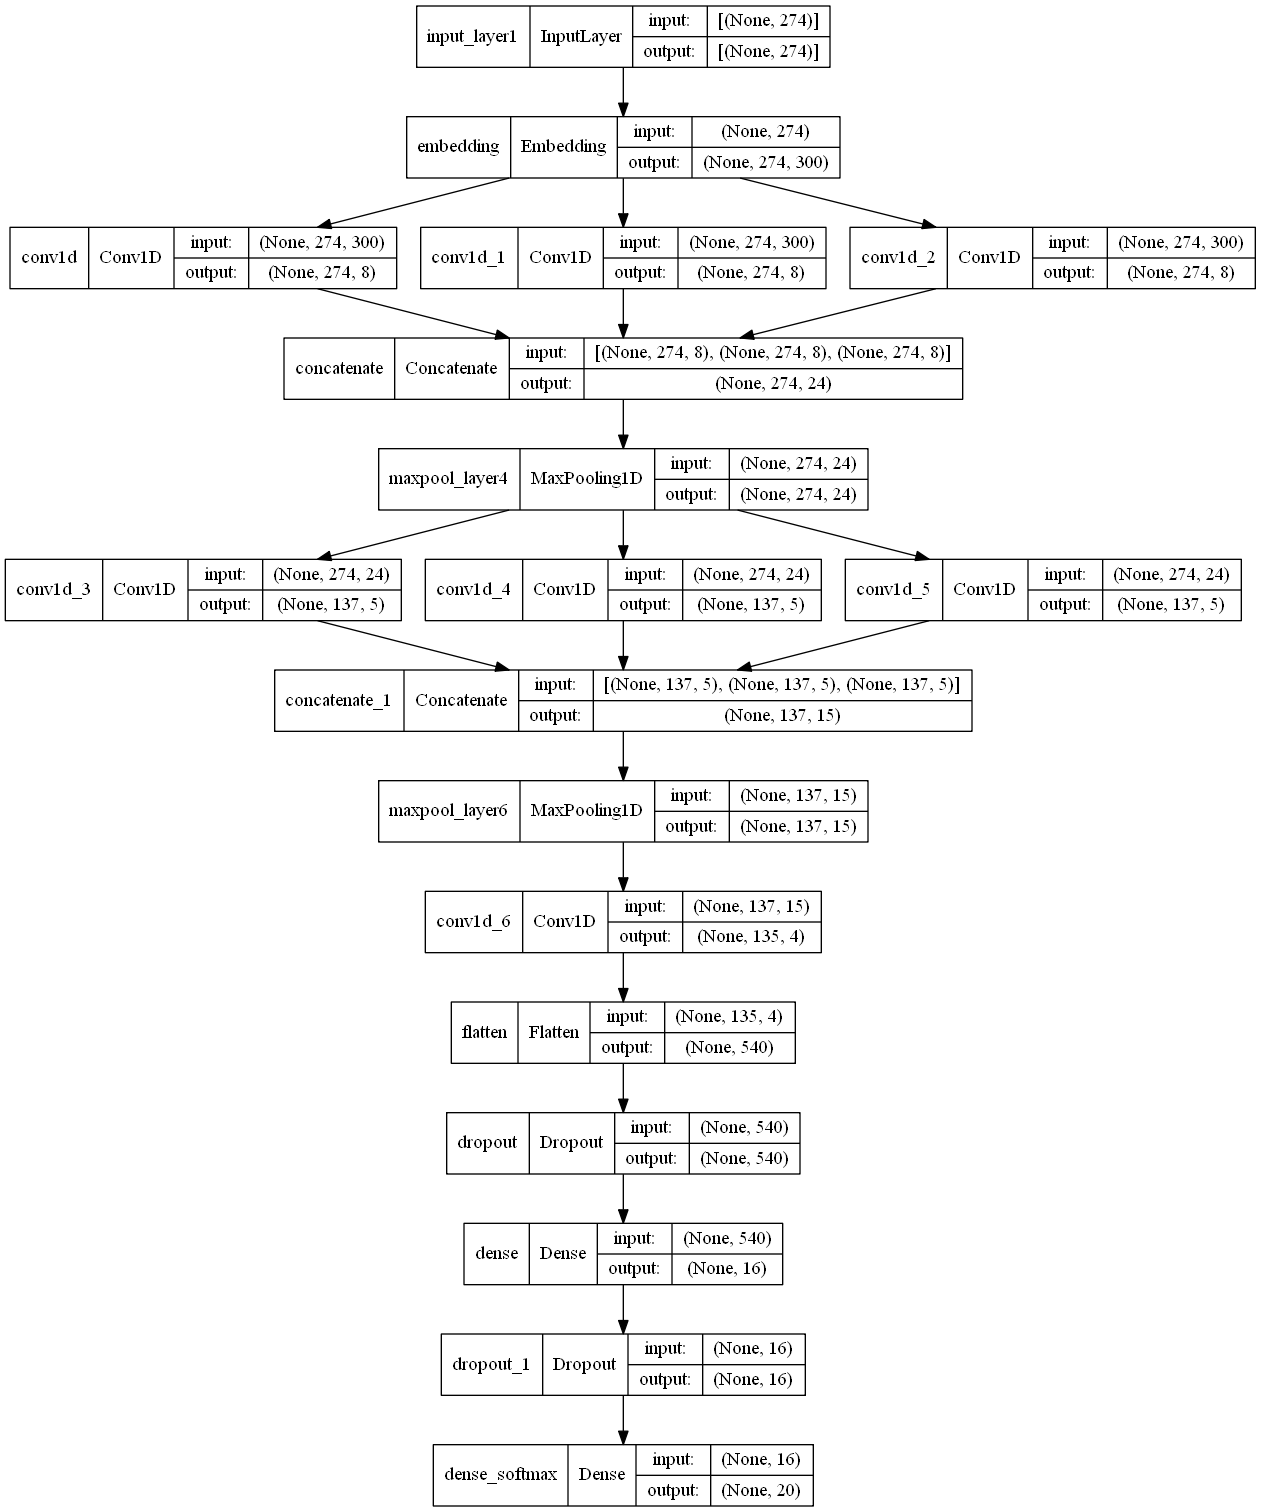

In [80]:
#Plot the Model
#!pip install pydot
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
dot_img_file = './model_1.png'
tf.keras.utils.plot_model(best_model1, to_file=dot_img_file, show_shapes=True)

## Observations

### Preprocessing
* Removed the stemming and lemmatization because GloVe embedding does not have stemmed and lemmatized words

### Model 1 
#### Behavioral
* Do not be in hurry to build model architecture to save the time, it will cost you more time debugging
* Do not feel tense and overwhelmed if the model architecture defined by you is not working.
* Instead, have cup of coffee or go for one day long drive, feel sensible and continue altering the model architecture.
* Try to focus on something which you find more daunting or more easy. There is high chance that issue lies there.
* Dont give up because you feel frustrated, tense and less confident.

#### Technical
* Always print the results to ensure whether its working the way you expect.
* I wanted to check word count but, I was checking character count by mistake. Scentence length was later reduced from 2000 to aroung 250 words. By mistake, I was considering 2000 as maximum words in sequence, those are in fact number of characters. This was introducing more number of zeros abd less sequence numbers in the 'number sequences' created from sequences. It was then hampering the neural networks training .
* By mistake, I was flattening the already flattened layer. Model was really misbehaving. High accuracy 0.85 and low f1 score 0.05 around. And vice versa when learning rate was altered. Faced the issue of exploding gradients, controled exploding gradients by gradient clipping by option of keras Adam optimizer clipnorm=1.
* Model training stopped misbehaving when one of the Flatten later was removed. Just kept onr Flatten layer in the model.
* Less kernel size captures more detailed word level features. Larger kernel size captures the global meaning but not the detailed meaning. Less kernel size is used which is 2 since Conv1D, if it was Conv2d then the kernel size could be 2x2. Kernel size was changed from 5 to 2 here.
* ReLU activation and 'He Uniform' weight initializer was provided to all Conv1D
* Do not create the instance of 'He Uniform' kernel initializer first and do not assign that instance to all Conv1D layers; because, it initializes all Conv1D kernels to same values, hence wont help capture the different aspects of features from the input data
* Instead, directly assign to kernel_initializer argument as below.
* i1            = Conv1D(8,  2, padding='same', strides = 1, activation='relu', kernel_initializer = tf.keras.initializers.HeUniform())(x)
* Writing custom keras metric does not accept normal python variables, it accepts to calculate on top of tensors.
* Total words in vocablary of entire training corpus are 86583. In the GloVe vector; the 34781 numbers of words not found, zero value used for all dimensions in the embedding metrics.
* Use the activation function ReLu with He initializer. And try to keep default learning rate 0.001 for Adam optimizer, adam in most of the cases works better with that default learning rate
* For almost 18% of the documents in training set, class cannot be predicted.
* For almost 24% of the documents in test set, class cannot be predicted.
* Model is bit overfitted but can give acceptable results
* train_acc: 0.857, test_acc: 0.666
* train_fbeta_score: 0.840, test_fbeta_score: 0.668

#### Tensorboard (Red is train and blue is test)

In [91]:
from IPython.display import Image

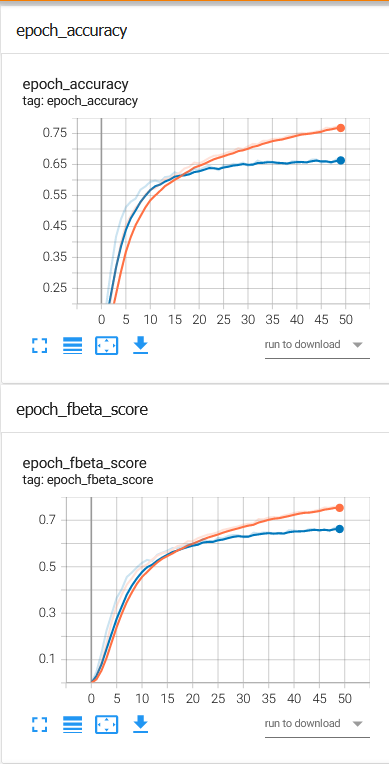

In [92]:
Image("TSBoard_Scalars1.png")

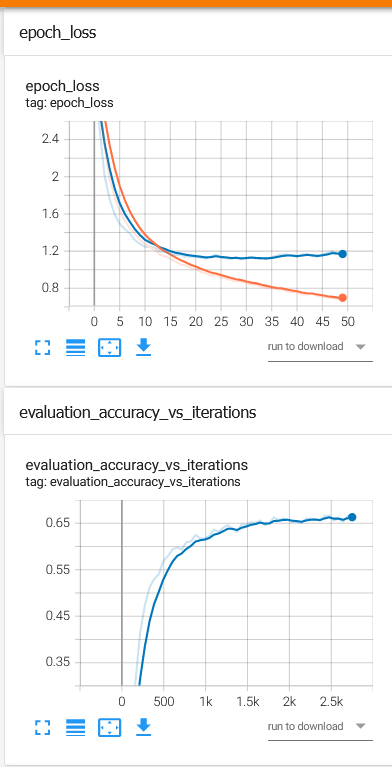

In [93]:
Image("TSBoard_Scalars2.png")

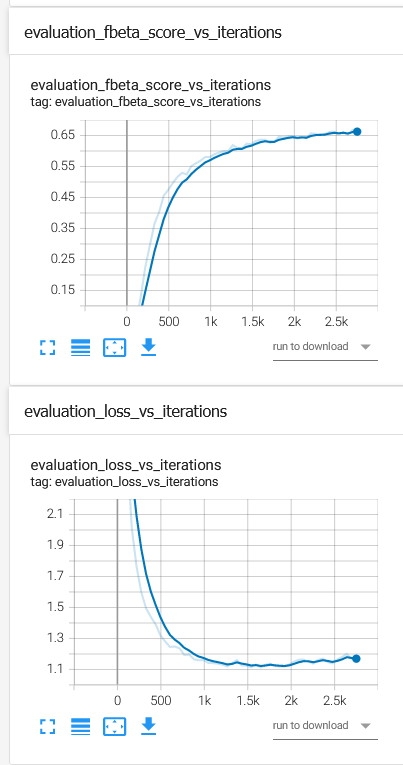

In [94]:
Image("TSBoard_Scalars3.png")